# Facial Emotion Recognition (FER) with PyTorch and Data Augmentation
# Google Colab Implementation

**Step-1 Imports**

1.   Mount Google Drive (Run this cell first)
2.   Change the path above to match where you've stored the FER2013 dataset in your Drive
3.   Set GPU
4. Install import



In [25]:

# Mount Google Drive (Run this cell first)
from google.colab import drive
drive.mount('/content/drive')

# Install required packages if not already installed
!pip install optuna plotly

# dataset
data_path = '/content/drive/My Drive/Colab Notebooks/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv'


# GPU
import torch
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

import numpy as np
import random
seed = 42 # random one
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import time
import optuna
from torchvision.models.feature_extraction import create_feature_extractor


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu


**Step-2 Exploratory Data Analysis**


1.   Analyze the dataset distribution
2.   Check the Usage split
3.   Visualize emotion distribution as pie chart
4.   Bar chart of emotion distribution by usage
5.   Analyze pixel intensity distribution
6.   Function to display example images for each emotion
7.   Function to display multiple examples of a specific emotion
8.   Analyze pixel intensity distribution
9.   Compare average faces across emotion
10.  Analyze class imbalance with ratio visualization





Loading the dataset...
Dataset shape: (35887, 3)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   Usage    35887 non-null  object
 2   pixels   35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
None

First few rows:


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...



Emotions mapped: {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

Emotion counts:
emotion
Angry       4953
Disgust      547
Fear        5121
Happy       8989
Sad         6077
Surprise    4002
Neutral     6198
Name: count, dtype: int64

Usage split:
Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64


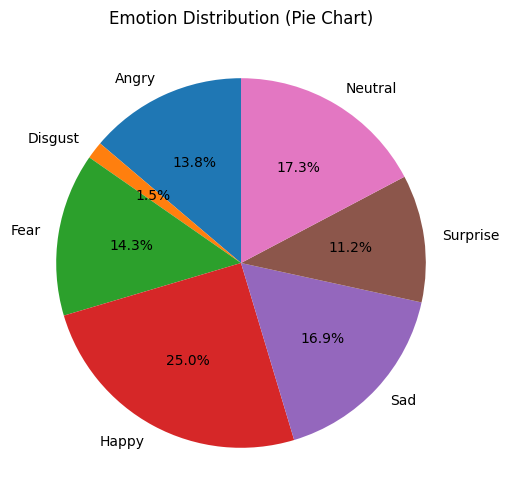

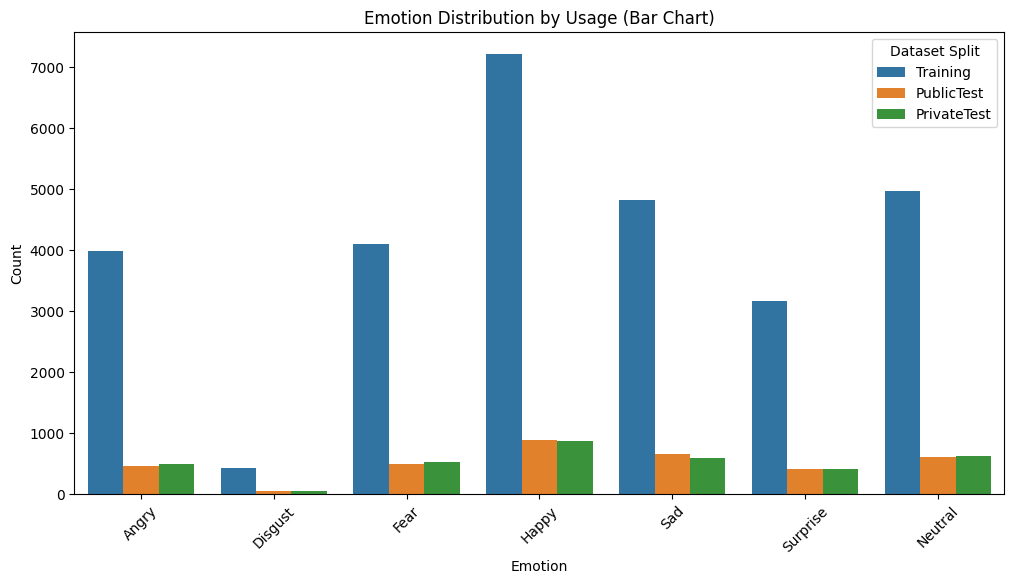

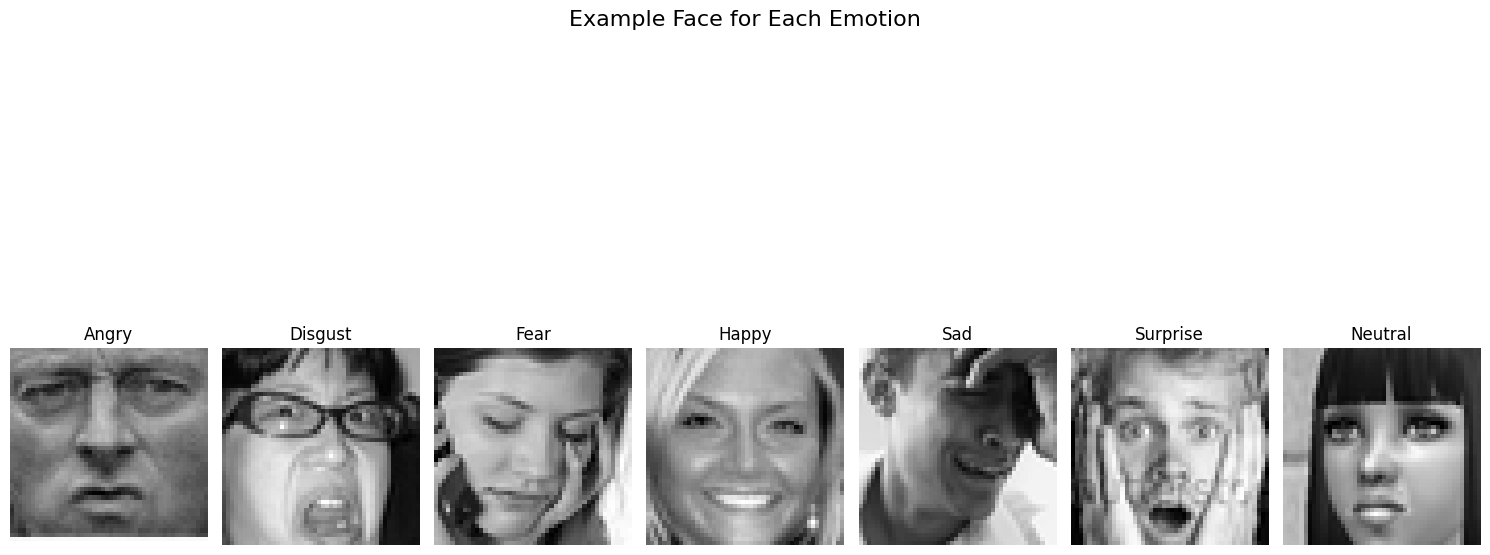

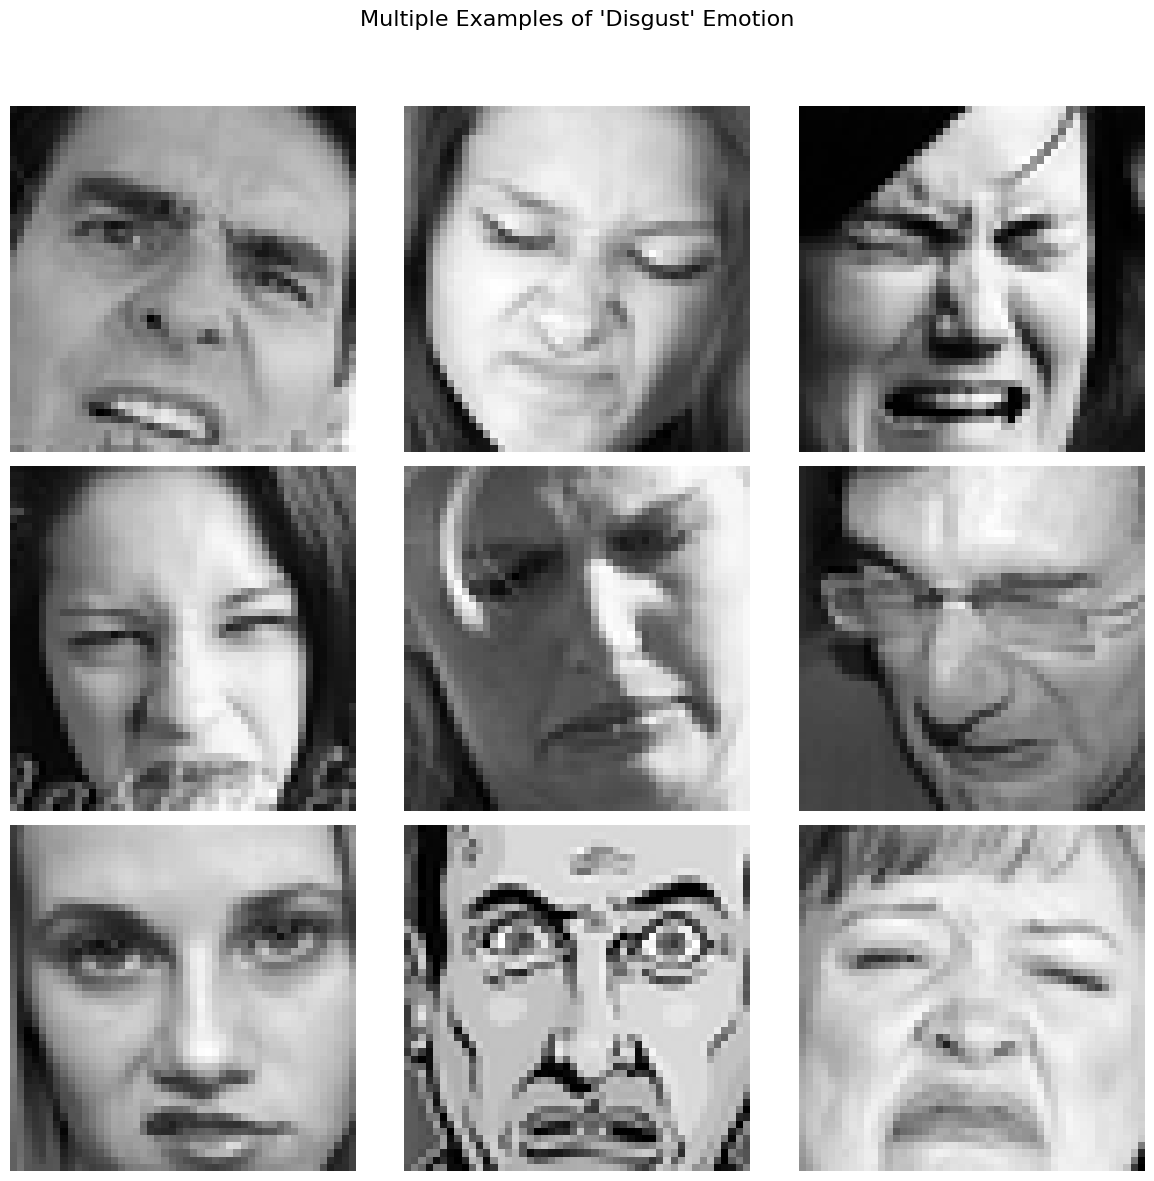

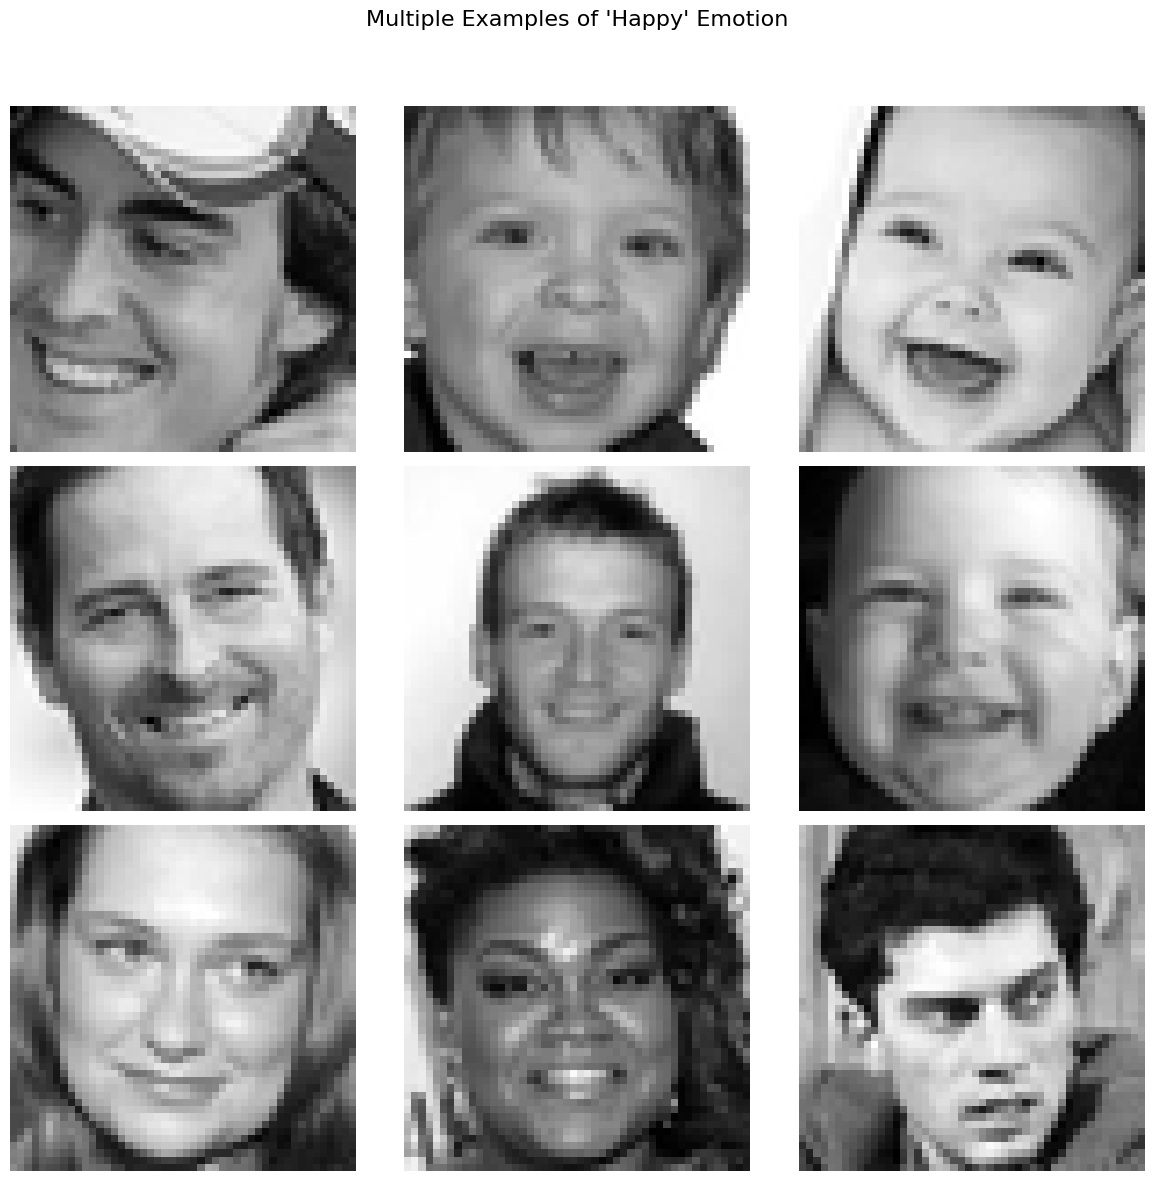

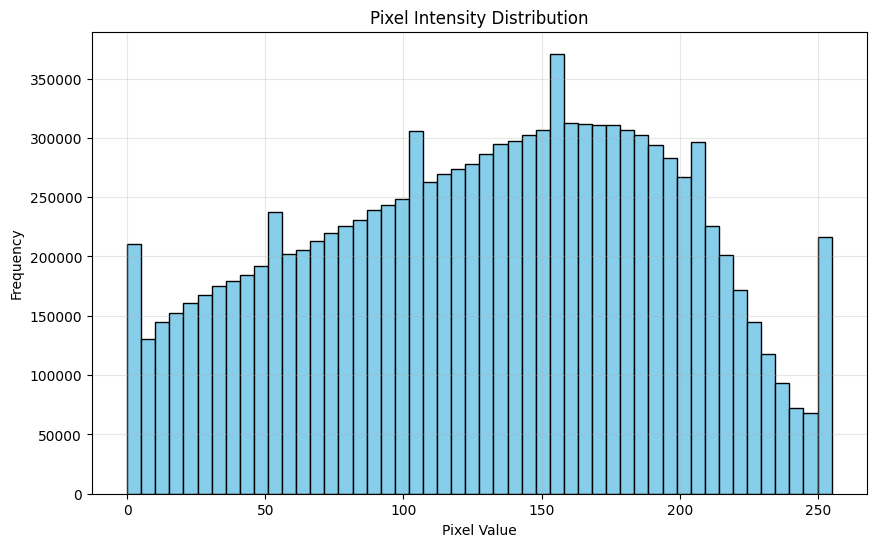

Pixel Statistics:
Mean: 129.71
Median: 135.0
Min: 0
Max: 255
Standard Deviation: 65.06


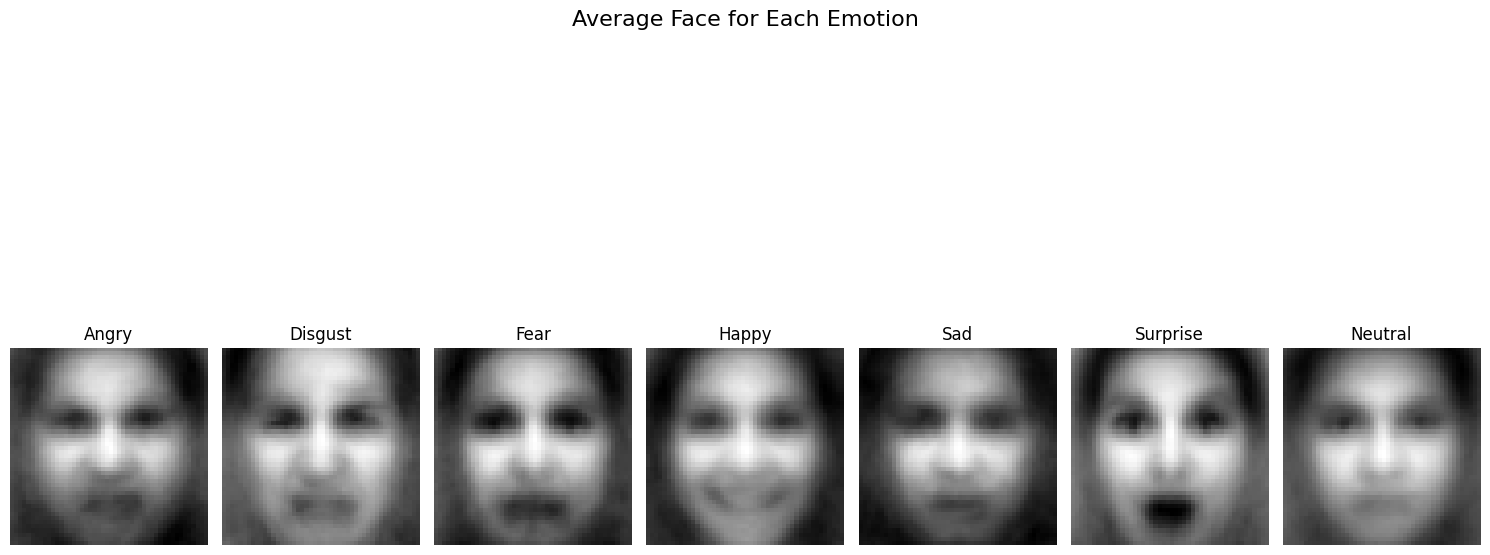

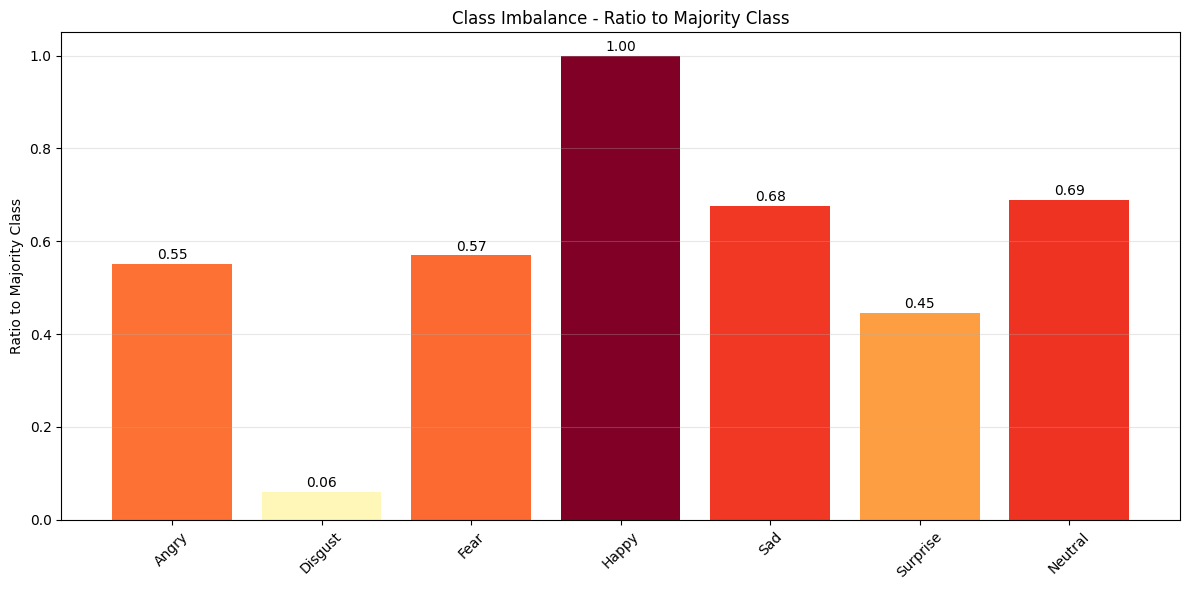

Class Imbalance Summary:
Angry: 4953 samples (13.8% of dataset, 0.55x ratio to majority)
Disgust: 547 samples (1.5% of dataset, 0.06x ratio to majority)
Fear: 5121 samples (14.3% of dataset, 0.57x ratio to majority)
Happy: 8989 samples (25.0% of dataset, 1.00x ratio to majority)
Sad: 6077 samples (16.9% of dataset, 0.68x ratio to majority)
Surprise: 4002 samples (11.2% of dataset, 0.45x ratio to majority)
Neutral: 6198 samples (17.3% of dataset, 0.69x ratio to majority)

 EDA Summary
1. Dataset contains 48x48 grayscale facial images with 7 emotion categories
2. Total sample count: 35887 images
3. Class imbalance: 'Happy' is the most common emotion (~25.0% of dataset)
4. 'Disgust' is severely underrepresented (~1.5% of dataset)
5. Pixel intensities are distributed across the full 0-255 range
6. Average faces show distinct patterns for different emotions
7. Data is already split into Training, PublicTest, and PrivateTest sets
8. The substantial class imbalance will be addressed through c

In [28]:
# # Install required packages if not already installed
# # Set path to your dataset
# data_path = '/content/drive/MyDrive/Assignment_roosh/train.csv'
# # Change the path above to match where you've stored the FER2013 dataset in your Drive
data_path = '/content/drive/My Drive/Colab Notebooks/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv'


print("Loading the dataset...")
df = pd.read_csv(data_path, on_bad_lines='skip')
df.columns = df.columns.str.strip()

# Display basic dataset info
print(f"Dataset shape: {df.shape}")
print("\nDataset info:")
print(df.info())

print("\nFirst few rows:")
display(df.head())

emotion_dict = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}
print("\nEmotions mapped:", emotion_dict)

# Analyze the dataset distribution
emotion_counts = df['emotion'].value_counts().sort_index()
emotion_counts_mapped = emotion_counts.rename(index=emotion_dict)
print("\nEmotion counts:")
print(emotion_counts_mapped)

# We wwill create a new column if its not being available in the dataset
if 'Usage' not in df.columns:
    print("\nCreating custom train/val/test split since 'Usage' column is missing")

    # We will Randomly assign 80% training, 10% validation, 10% test
    # First split: 80% train, 20% temp
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['emotion'])

    # Second split: 50% validation, 50% test (from the 20% temp)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['emotion'])

    train_df = train_df.copy()
    val_df = val_df.copy()
    test_df = test_df.copy()

    train_df['Usage'] = 'Training'
    val_df['Usage'] = 'PublicTest'
    test_df['Usage'] = 'PrivateTest'

    df = pd.concat([train_df, val_df, test_df])

    # Check the Usage split
    usage_counts = df['Usage'].value_counts()
    print("\nCustom Usage split:")
    print(usage_counts)
else:

    usage_counts = df['Usage'].value_counts()
    print("\nUsage split:")
    print(usage_counts)

# Visualize emotion distribution as pie chart
plt.figure(figsize=(10, 6))
plt.pie(emotion_counts, labels=[emotion_dict[i] for i in emotion_counts.index],
        autopct='%1.1f%%', startangle=90)
plt.title("Emotion Distribution (Pie Chart)")
plt.show()

# Bar chart of emotion distribution by usage
plt.figure(figsize=(12, 6))
sns.countplot(x='emotion', hue='Usage', data=df)
plt.xticks(ticks=range(len(emotion_dict)), labels=list(emotion_dict.values()), rotation=45)
plt.title("Emotion Distribution by Usage (Bar Chart)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.legend(title='Dataset Split')
plt.show()



def display_emotion_examples(df, emotions_per_row=7):

  """
  Function to display example images for each emotion
  Input Parameter - dataframe, Emotions per row =7

  """
  plt.figure(figsize=(15, 8))

  for i, emotion_idx in enumerate(sorted(emotion_dict.keys())):
      emotion_samples = df[df['emotion'] == emotion_idx]
      sample = emotion_samples.sample(1).iloc[0]
      pixels = np.array(sample['pixels'].split(), dtype=np.uint8).reshape(48, 48) #Convert pixel string to image
      plt.subplot(1, len(emotion_dict), i+1)
      plt.imshow(pixels, cmap='gray')
      plt.title(emotion_dict[emotion_idx])
      plt.axis('off')

  plt.suptitle("Example Face for Each Emotion", fontsize=16)
  plt.tight_layout()
  plt.subplots_adjust(top=0.85)
  plt.show()


display_emotion_examples(df)


def display_multiple_examples(df, emotion_idx, num_examples=10):
  """
  Function to display multiple examples of a specific emotion

  Input Parameter - dataframe, Emotion index, examples=10

  """
  emotion_name = emotion_dict[emotion_idx]
  emotion_samples = df[df['emotion'] == emotion_idx]

  # Calculate grid dimensions
  grid_size = int(np.ceil(np.sqrt(num_examples)))
  plt.figure(figsize=(12, 12))

  samples = emotion_samples.sample(min(num_examples, len(emotion_samples)))

  for i, (_, sample) in enumerate(samples.iterrows()):
      if i >= num_examples:
          break
      pixels = np.array(sample['pixels'].split(), dtype=np.uint8).reshape(48, 48) # To Convert pixel string to image
      plt.subplot(grid_size, grid_size, i+1)
      plt.imshow(pixels, cmap='gray')
      plt.axis('off')

  plt.suptitle(f"Multiple Examples of '{emotion_name}' Emotion", fontsize=16)
  plt.tight_layout()
  plt.subplots_adjust(top=0.9)
  plt.show()

# To Display multiple examples of 'Disgust' (the minority class)
display_multiple_examples(df, emotion_idx=1, num_examples=9)  # Disgust

# To Display multiple examples of 'Happy' (the majority class)
display_multiple_examples(df, emotion_idx=3, num_examples=9)  # Happy


def analyze_pixel_intensities(df):
  """
   Analyze pixel intensity distribution
   Input Parameter - dataframe
  """

  sample_size = min(5000, len(df))
  samples = df.sample(sample_size)

  all_pixels = []
  for pixel_str in samples['pixels']:
    pixels = np.array(pixel_str.split(), dtype=np.uint8)
    all_pixels.extend(pixels)

  all_pixels = np.array(all_pixels)

  plt.figure(figsize=(10, 6))
  plt.hist(all_pixels, bins=50, color='skyblue', edgecolor='black')
  plt.title('Pixel Intensity Distribution')
  plt.xlabel('Pixel Value')
  plt.ylabel('Frequency')
  plt.grid(alpha=0.3)
  plt.show()


  print(f"Pixel Statistics:")
  print(f"Mean: {np.mean(all_pixels):.2f}")
  print(f"Median: {np.median(all_pixels)}")
  print(f"Min: {np.min(all_pixels)}")
  print(f"Max: {np.max(all_pixels)}")
  print(f"Standard Deviation: {np.std(all_pixels):.2f}")

analyze_pixel_intensities(df)


def display_average_faces(df):
  """
  Compare average faces across emotion
  Input Parameter - dataframe

  """

  plt.figure(figsize=(15, 8))

  for i, emotion_idx in enumerate(sorted(emotion_dict.keys())):
      emotion_samples = df[df['emotion'] == emotion_idx] # Get subset of data for this emotion
      avg_face = np.zeros((48, 48))
      sample_count = min(1000, len(emotion_samples)) # Limit is 100
      samples = emotion_samples.sample(sample_count)

      for _, sample in samples.iterrows():
          pixels = np.array(sample['pixels'].split(), dtype=np.uint8).reshape(48, 48)
          avg_face += pixels
      avg_face = avg_face / sample_count # Avg calc

      plt.subplot(1, len(emotion_dict), i+1)
      plt.imshow(avg_face, cmap='gray')
      plt.title(emotion_dict[emotion_idx])
      plt.axis('off')

  plt.suptitle("Average Face for Each Emotion", fontsize=16)
  plt.tight_layout()
  plt.subplots_adjust(top=0.85)
  plt.show()


display_average_faces(df)


def analyze_class_imbalance(df):
  """
  Analyze class imbalance with ratio visualization
  Input Parameter - dataframe

  """

  emotion_counts = df['emotion'].value_counts().sort_index()
  max_count = emotion_counts.max()


  ratios = emotion_counts / max_count  # To Calculate ratios compared to the majority class
  plt.figure(figsize=(12, 6))
  colors = plt.cm.YlOrRd(ratios)

  plt.bar(range(len(emotion_dict)), ratios, color=colors)
  plt.xticks(range(len(emotion_dict)), [emotion_dict[i] for i in range(len(emotion_dict))], rotation=45)
  plt.ylabel('Ratio to Majority Class')
  plt.title('Class Imbalance - Ratio to Majority Class')
  plt.grid(axis='y', alpha=0.3)


  for i, ratio in enumerate(ratios):
      plt.text(i, ratio + 0.01, f'{ratio:.2f}', ha='center') # To Add ratio values on top of bars

  plt.tight_layout()
  plt.show()
  print("Class Imbalance Summary:")
  for i, count in enumerate(emotion_counts):
      print(f"{emotion_dict[i]}: {count} samples ({count/len(df):.1%} of dataset, {ratios[i]:.2f}x ratio to majority)")


analyze_class_imbalance(df)

# Final Summary of EDA findings
print("\n EDA Summary")
print("1. Dataset contains 48x48 grayscale facial images with 7 emotion categories")
print(f"2. Total sample count: {len(df)} images")
print(f"3. Class imbalance: 'Happy' is the most common emotion (~{100*df[df['emotion']==3].shape[0]/len(df):.1f}% of dataset)")
print(f"4. 'Disgust' is severely underrepresented (~{100*df[df['emotion']==1].shape[0]/len(df):.1f}% of dataset)")
print("5. Pixel intensities are distributed across the full 0-255 range")
print("6. Average faces show distinct patterns for different emotions")
print("7. Data is already split into Training, PublicTest, and PrivateTest sets")
print("8. The substantial class imbalance will be addressed through class weighting during training")

**Step-3: DATA PREPROCESSING AND AUGMENTATION**



1.   custom dataset class
  1.   Add Gaussian noise to an image tensor
  2.   Add random black blocks to simulate occlusion
  3.   Add a central black block to the image
  4.   Custom transform class for advanced augmentations
  5.   Show examples of augmented images



Train, val, test sizes: 28709, 3589, 3589
Class weights for handling imbalance: tensor([0.4800, 4.3982, 0.4681, 0.2658, 0.3970, 0.6047, 0.3862])
Datasets and dataloaders created successfully!


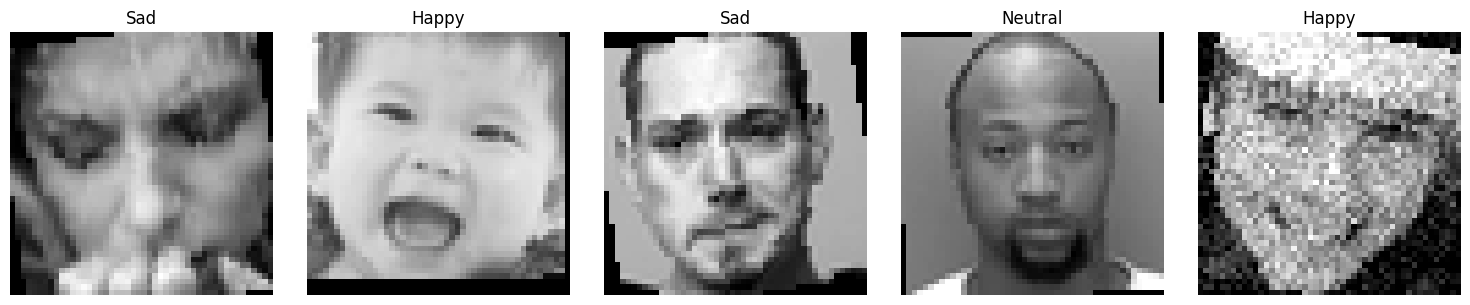

In [29]:

# Create a custom dataset class for FER2013
class FERDataset(Dataset):
    """Custom dataset class for FER2013 data"""
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Parse the pixel string into a 48x48 array
        pixel_str = self.data.iloc[idx]['pixels']
        img = np.array(pixel_str.split(), dtype=np.uint8).reshape(48, 48, 1)
        label = self.data.iloc[idx]['emotion']
        img = Image.fromarray(img.squeeze(), mode='L')  # Convert to PIL Image (grayscale)
        if self.transform:
            img = self.transform(img)
        return img, label

# Define custom augmentation functions
def add_gaussian_noise(image, noise_factor=0.3):

    """
    Add Gaussian noise to an image tensor
    Input Parameter : Image, noise factor
    Return Parameter:  Torchclamp

    """
    image = torch.tensor(image) if not isinstance(image, torch.Tensor) else image
    noisy = image + torch.randn_like(image) * noise_factor
    return torch.clamp(noisy, 0., 1.)

def add_random_blocks(image, n_blocks=3, block_size=5):

    """
    Add random black blocks to simulate occlusion
    nput Parameter : Image, range_blcoks and block sise
    Return parameters: image array

    """
    image_np = np.array(image).copy()
    h, w = image_np.shape[:2]

    for _ in range(n_blocks):
        y = np.random.randint(0, h - block_size)
        x = np.random.randint(0, w - block_size)
        image_np[y:y+block_size, x:x+block_size] = 0

    return Image.fromarray(image_np)

def add_central_block(image, block_size=10):

    """
    Add a central black block to the image
    Add random black blocks to simulate occlusion
    Input Parameter : Image and block sise
    Return parameters: image array

    """
    image_np = np.array(image).copy()
    h, w = image_np.shape[:2]

    y_center = h // 2
    x_center = w // 2

    y_start = y_center - block_size // 2
    x_start = x_center - block_size // 2

    image_np[y_start:y_start+block_size, x_start:x_start+block_size] = 0

    return Image.fromarray(image_np)

# Custom transform to apply advanced augmentations
class AdvancedAugmentation:
    """
    Custom transform class for advanced augmentations

    """
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img):
        aug_type = np.random.choice([0, 1, 2, 3], p=[0.4, 0.2, 0.2, 0.2])  # Probability distribution

        if np.random.random() > self.p:
            return img
        if aug_type == 0: # no change
            return img
        elif aug_type == 1: # Gaussian noise
            img_tensor = transforms.ToTensor()(img)
            noisy_img = add_gaussian_noise(img_tensor, noise_factor=0.1)
            return transforms.ToPILImage()(noisy_img)
        elif aug_type == 2: # Adding random blocks (occlusion)
            return add_random_blocks(img, n_blocks=2, block_size=5)
        elif aug_type == 3:
            return add_central_block(img, block_size=8)  # Add central block

# Split data based on 'Usage' column
train_df = df[df['Usage'] == 'Training']
val_df = df[df['Usage'] == 'PublicTest']
test_df = df[df['Usage'] == 'PrivateTest']
print(f"Train, val, test sizes: {len(train_df)}, {len(val_df)}, {len(test_df)}")

# Basic transformation for validation and test
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Advanced transformations for training
train_transform = transforms.Compose([
    # Basic transformations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),

    # Additional transformations from the document
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
    transforms.RandomApply([transforms.RandomAffine(0, translate=(0.1, 0.1))], p=0.3),  # Width/height shift
    transforms.RandomApply([transforms.RandomResizedCrop(48, scale=(0.8, 1.0))], p=0.3),  # Zoom effect

    # Custom advanced augmentations
    AdvancedAugmentation(p=0.5),

    # Convert to tensor and normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


train_dataset = FERDataset(train_df, transform=train_transform)
val_dataset = FERDataset(val_df, transform=val_test_transform)
test_dataset = FERDataset(test_df, transform=val_test_transform)

# Compute class weights to handle imbalance
class_counts = train_df['emotion'].value_counts().sort_index()
class_weights = 1.0 / class_counts
class_weights = torch.tensor([class_weights[i] for i in range(len(class_weights))]).float()
class_weights = class_weights / class_weights.sum() * len(class_weights)
print("Class weights for handling imbalance:", class_weights)


batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print("Datasets and dataloaders created successfully!")

def show_augmented_samples(dataset, num_samples=5):

    """
    Show examples of augmented images
    Input Parameter : dataset and samples


    """
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        # Convert from tensor to numpy for display
        img_np = img.squeeze().numpy()
        img_np = (img_np * 0.5) + 0.5  # Unnormalize

        axes[i].imshow(img_np, cmap='gray')
        axes[i].set_title(f"{emotion_dict[label]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display some augmented training samples
show_augmented_samples(train_dataset)

**Step-4 MODEL ARCHITECTURE**



1.   Residual block for building CNN with skip connections
    1. CNN model for facial emotion recognition with residual connections
    2. Initialize weights similar to Keras for better performance
        Based on the article about Keras vs PyTorch performance differences





In [31]:

# Define a residual block for our CNN
class ResidualBlock(nn.Module):
    """
    Residual block for building CNN with skip connections

    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)  # Residual connection
        out = self.relu(out)
        return out

# Our Emotion Recognition CNN model
class EmotionRecognitionCNN(nn.Module):
    """
    CNN model for facial emotion recognition with residual connections

    """
    def __init__(self, num_classes=7):
        super(EmotionRecognitionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.res1 = ResidualBlock(64, 128, stride=2)
        self.res2 = ResidualBlock(128, 256, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(128, num_classes)

        # Initialize weights using Keras-style initialization
        self._initialize_weights()

    def _initialize_weights(self):

        """
        Initialize weights similar to Keras for better performance
        Based on the article about Keras vs PyTorch performance differences

        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Keras uses 'glorot_uniform' (aka Xavier uniform) by default for Conv2D
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                if m == self.fc2:  # Last layer
                    # Keras uses 'random_normal' with std=0.05 for the last layer
                    nn.init.normal_(m.weight, mean=0, std=0.05)
                else:
                    # Keras uses 'glorot_uniform' by default
                    nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.layer1(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model and move to device
model = EmotionRecognitionCNN().to(device)
print(model)

EmotionRecognitionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (res2): ResidualBlock(
    (conv1): Conv2d(

**Step-5:  MODEL TRAINING**

1.   Train_model
2.   Plot training and validation curves using Plotly





In [32]:

# Train the model
def train_model(model, train_loader, val_loader, class_weights, num_epochs=30, save_path='best_model.pth'):
    """
    Train the model and validate after each epoch
    Input Paramter - Model, Train_loader, val_loader, class_weight, num_epochs, savie best model
    Return Paramter-: model, train_losses, val_losses, val_accuracies

    """
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=6, cooldown=20)

    print("Note on Keras vs PyTorch performance:")
    print("1. Custom weight initialization matching Keras defaults (glorot_uniform, random_normal with std=0.05)")
    print("2. Matching optimizer parameters between PyTorch and Keras")
    print("3. Using the same learning rate scheduler parameters")
    print("4. Class balancing with weighted loss function")


    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        epoch_start_time = time.time()


        model.train()
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

            # Print progress every 20 batches
            if (i+1) % 20 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        # We Update learning rate based on validation loss
        scheduler.step(epoch_val_loss)

        # Saving the best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved to {save_path}")

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%, "
              f"Time: {epoch_time:.2f}s, "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Saving checkpoint every 5 epochs (to prevent loss of work if Colab disconnects), as the old run got disconnected
        if (epoch + 1) % 5 == 0:
            checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
                'best_val_loss': best_val_loss
            }, checkpoint_path)
            print(f"Checkpoint saved to {checkpoint_path}")

    # Load best model
    model.load_state_dict(torch.load(save_path))

    # Plot training curves
    plot_training_curves(train_losses, val_losses, val_accuracies)

    return model, train_losses, val_losses, val_accuracies

def plot_training_curves(train_losses, val_losses, val_accuracies):

    """
    Plot training and validation curves using Plotly

    """
    epochs = range(1, len(train_losses) + 1)

    # Loss curves
    fig_loss = go.Figure()
    fig_loss.add_trace(go.Scatter(x=list(epochs), y=train_losses, mode='lines', name='Training Loss'))
    fig_loss.add_trace(go.Scatter(x=list(epochs), y=val_losses, mode='lines', name='Validation Loss'))
    fig_loss.update_layout(title='Training and Validation Loss',
                          xaxis_title='Epochs',
                          yaxis_title='Loss')
    fig_loss.show()

    # Accuracy curve
    fig_acc = go.Figure()
    fig_acc.add_trace(go.Scatter(x=list(epochs), y=val_accuracies, mode='lines', name='Validation Accuracy'))
    fig_acc.update_layout(title='Validation Accuracy',
                         xaxis_title='Epochs',
                         yaxis_title='Accuracy (%)')
    fig_acc.show()

# Set the number of epochs (adjust based on your needs and time constraints)
num_epochs = 30  # For full training. Use 5-10 for quick testing.

# Optional: load a checkpoint if training was interrupted
load_checkpoint = False  # Set to True if you want to resume training
checkpoint_path = "checkpoint_epoch_10.pth"  # Change to your checkpoint path

if load_checkpoint and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Loaded checkpoint from epoch {start_epoch-1}")
else:
    # Train the model from scratch
    save_path = 'best_model.pth'
    model, train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, class_weights, num_epochs=num_epochs, save_path=save_path)


Note on Keras vs PyTorch performance:
1. Custom weight initialization matching Keras defaults (glorot_uniform, random_normal with std=0.05)
2. Matching optimizer parameters between PyTorch and Keras
3. Using the same learning rate scheduler parameters
4. Class balancing with weighted loss function
Epoch 1/30, Batch 20/225, Loss: 2.1278
Epoch 1/30, Batch 40/225, Loss: 1.9062
Epoch 1/30, Batch 60/225, Loss: 1.9379
Epoch 1/30, Batch 80/225, Loss: 1.8889
Epoch 1/30, Batch 100/225, Loss: 1.9769
Epoch 1/30, Batch 120/225, Loss: 1.9390
Epoch 1/30, Batch 140/225, Loss: 1.9062
Epoch 1/30, Batch 160/225, Loss: 1.8853
Epoch 1/30, Batch 180/225, Loss: 1.8881
Epoch 1/30, Batch 200/225, Loss: 1.9038
Epoch 1/30, Batch 220/225, Loss: 1.9169
Model saved to best_model.pth
Epoch 1/30, Train Loss: 1.9407, Val Loss: 2.0904, Val Accuracy: 14.66%, Time: 443.45s, LR: 0.001000
Epoch 2/30, Batch 20/225, Loss: 1.9187
Epoch 2/30, Batch 40/225, Loss: 1.9164
Epoch 2/30, Batch 60/225, Loss: 1.9255
Epoch 2/30, Batch 

KeyboardInterrupt: 

**Step-6: MODEL EVALUATION**


1.   Evaluate the model on the test set and display metrics
2.   Create and display a confusion matrix visualization
3.   Analyze and display per-class performance metrics




Final test accuracy: 18.39%

Classification Report:
              precision    recall  f1-score   support

       Angry       0.16      0.13      0.15       491
     Disgust       0.03      0.09      0.05        55
        Fear       0.08      0.02      0.04       528
       Happy       0.32      0.19      0.24       879
         Sad       0.23      0.11      0.15       594
    Surprise       0.17      0.82      0.28       416
     Neutral       0.20      0.00      0.00       626

    accuracy                           0.18      3589
   macro avg       0.17      0.20      0.13      3589
weighted avg       0.21      0.18      0.14      3589



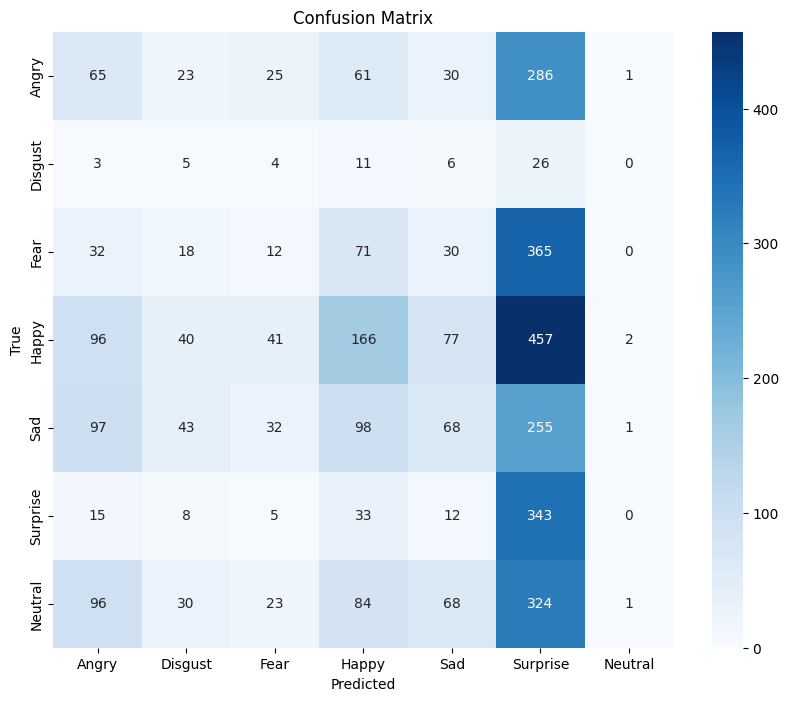

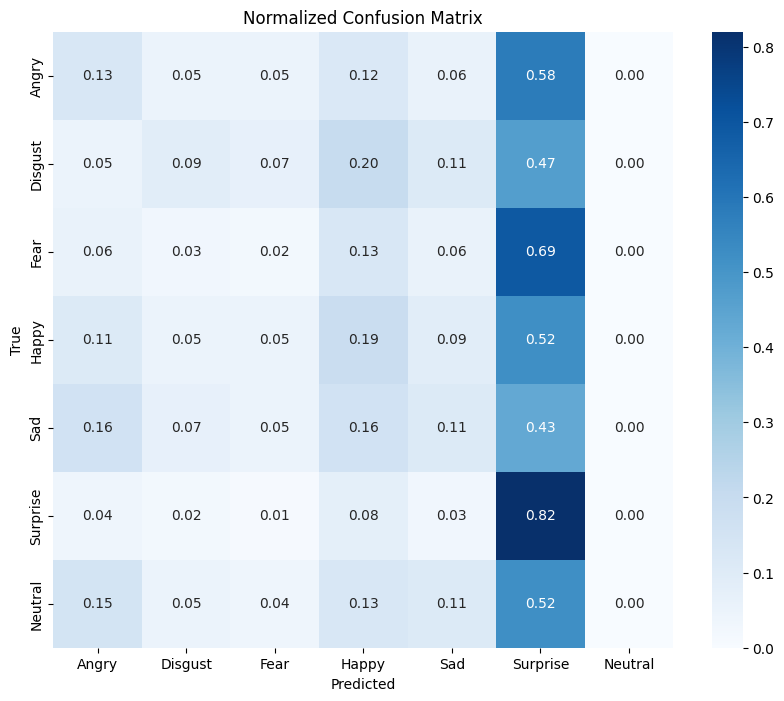

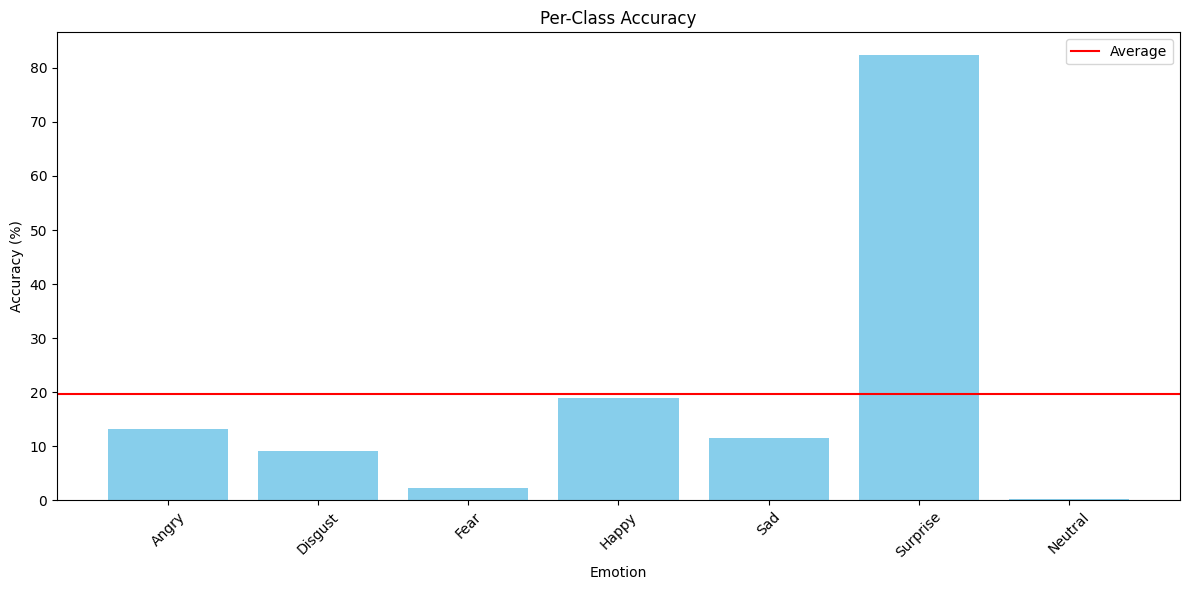

Per-class accuracy:
Angry: 13.24%
Disgust: 9.09%
Fear: 2.27%
Happy: 18.89%
Sad: 11.45%
Surprise: 82.45%
Neutral: 0.16%


In [21]:

# Evaluate the model on test data
def evaluate_model(model, test_loader, device, emotion_dict):
    """
    Evaluate the model on the test set and display metrics
    Input Parameter- model, test_loader, device, emotion_dict
    Return Parameter- test_accuracy, predictions, true_labels

    """
    model.eval()
    test_correct = 0
    test_total = 0
    predictions = []
    true_labels = []

    # Collect predictions
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())


    test_accuracy = 100 * test_correct / test_total
    print(f"\nFinal test accuracy: {test_accuracy:.2f}%")


    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=list(emotion_dict.values())))

    # Display confusion matrix
    display_confusion_matrix(true_labels, predictions, emotion_dict)

    return test_accuracy, predictions, true_labels

def display_confusion_matrix(true_labels, predictions, emotion_dict):

    """
    Create and display a confusion matrix visualization
    Input Parameter- true_labels, predictions, emotion_dict

    """
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(emotion_dict.values()),
                yticklabels=list(emotion_dict.values()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Normalize confusion matrix for better understanding of per-class performance
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.around(cm_norm, decimals=2)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=list(emotion_dict.values()),
                yticklabels=list(emotion_dict.values()))
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def analyze_class_performance(true_labels, predictions, emotion_dict):
    """
    Analyze and display per-class performance metrics

    """
    class_correct = [0] * len(emotion_dict)
    class_total = [0] * len(emotion_dict)

    for true, pred in zip(true_labels, predictions):
        class_total[true] += 1
        if true == pred:
            class_correct[true] += 1

    # Calculate per-class accuracy
    class_accuracy = [100 * correct / max(1, total)
                     for correct, total in zip(class_correct, class_total)]

    plt.figure(figsize=(12, 6))
    plt.bar(list(emotion_dict.values()), class_accuracy, color='skyblue')
    plt.axhline(y=sum(class_accuracy)/len(class_accuracy), color='r', linestyle='-', label='Average')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Emotion')
    plt.title('Per-Class Accuracy')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Per-class accuracy:")
    for emotion, accuracy in zip(emotion_dict.values(), class_accuracy):
        print(f"{emotion}: {accuracy:.2f}%")

# Evaluate the model
test_accuracy, predictions, true_labels = evaluate_model(model, test_loader, device, emotion_dict)

# Analyze per-class performance
analyze_class_performance(true_labels, predictions, emotion_dict)


**Step-7: MODEL INTERPRETABILITY**



1.   Generate Grad-CAM visualization for model interpretability
2.   Plot Grad-CAM visualization for sample images
3.   Visualize examples of misclassified images
4.   



In [ ]:
# def plot_gradcam_samples(data, dataset, model, emotion_dict, num_samples=5):
#     """
#     Plot Grad-CAM visualization for sample images
#     """
#     model.eval()

#     # Fix: Use indices directly from dataset range instead of DataFrame indices
#     indices = np.random.choice(len(dataset), num_samples, replace=False)

#     fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 3))

#     # Handle case where num_samples=1
#     if num_samples == 1:
#         axes = [axes]

#     for i, idx in enumerate(indices):
#         img, label = dataset[idx]
#         img = img.to(device)

#         with torch.no_grad():
#             output = model(img.unsqueeze(0))
#             _, pred = torch.max(output, 1)

#         # Get Grad-CAM visualization
#         gradcam_img = get_gradcam(model, img, pred.item())

#         if gradcam_img is not None:
#             axes[i].imshow(gradcam_img)
#             axes[i].set_title(f"Pred: {emotion_dict[pred.item()]}\nTrue: {emotion_dict[label]}")
#             axes[i].axis('off')
#         else:
#             axes[i].set_title("Grad-CAM failed")
#             axes[i].axis('off')

#     plt.tight_layout()
#     plt.show()

# # Generate Grad-CAM visualizations for sample test images
# try:
#     plot_gradcam_samples(test_df, test_dataset, model, emotion_dict)
#     print("Grad-CAM visualizations generated successfully!")
# except Exception as e:
#     print(f"Error generating Grad-CAM visualizations: {e}")

# # Visualize some misclassified examples
# def visualize_misclassifications(test_dataset, model, device, emotion_dict, num_samples=10):
#     """
#     Visualize examples of misclassified images
#     """
#     model.eval()
#     misclassified_indices = []
#     misclassified_predictions = []
#     misclassified_labels = []

#     # Find misclassified samples
#     with torch.no_grad():
#         for i in range(len(test_dataset)):
#             img, label = test_dataset[i]
#             img = img.unsqueeze(0).to(device)
#             output = model(img)
#             _, pred = torch.max(output, 1)

#             if pred.item() != label:
#                 misclassified_indices.append(i)
#                 misclassified_predictions.append(pred.item())
#                 misclassified_labels.append(label)

#                 if len(misclassified_indices) >= num_samples:
#                     break

#     # Display misclassified samples
#     if misclassified_indices:
#         num_to_display = min(num_samples, len(misclassified_indices))
#         fig, axes = plt.subplots(2, num_to_display//2 + num_to_display%2, figsize=(15, 6))
#         axes = axes.flatten()

#         for i in range(num_to_display):
#             idx = misclassified_indices[i]
#             img, _ = test_dataset[idx]
#             img_np = img.squeeze().numpy() * 0.5 + 0.5  # Denormalize

#             axes[i].imshow(img_np, cmap='gray')
#             axes[i].set_title(f"True: {emotion_dict[misclassified_labels[i]]}\nPred: {emotion_dict[misclassified_predictions[i]]}")
#             axes[i].axis('off')

#         plt.tight_layout()
#         plt.show()
#     else:
#         print("No misclassifications found in the samples checked!")

# # Visualize misclassified examples
# visualize_misclassifications(test_dataset, model, device, emotion_dict)




# # Grad-CAM visualization with error handling
# def get_gradcam(model, image, target_class):
#     """
#     Generate Grad-CAM visualization for model interpretability
#     Input Parameter - model, image, target_class
#     Return Parameter - superimposed images
#     """
#     model.eval()

#     # Check if the model has the res2 attribute for feature extraction
#     if not hasattr(model, 'res2'):
#         # Try to find the last convolutional layer or residual block
#         last_conv_layer = None
#         for name, module in model.named_modules():
#             if isinstance(module, nn.Conv2d):
#                 last_conv_layer = name
#             elif isinstance(module, ResidualBlock) or isinstance(module, ImprovedResidualBlock):
#                 last_conv_layer = name

#         if last_conv_layer is None:
#             print("Could not find a suitable convolutional layer for Grad-CAM")
#             return None

#         # Use the last convolutional layer found
#         feature_extractor = create_feature_extractor(model, return_nodes={last_conv_layer: 'features'})
#     else:
#         # Use res2 as specified in the original code
#         feature_extractor = create_feature_extractor(model, return_nodes={'res2': 'features'})

#     # Prepare image and enable gradients
#     image = image.unsqueeze(0).to(device)
#     image.requires_grad_()  # Enable gradients

#     try:
#         # Forward pass
#         outputs = model(image)
#         model.zero_grad()

#         # Safely access target class
#         if target_class < outputs.shape[1]:
#             score = outputs[0, target_class]
#             score.backward()
#         else:
#             print(f"Target class {target_class} is out of bounds for model output of shape {outputs.shape}")
#             return None

#         # Extract features and gradients
#         try:
#             features = feature_extractor(image)['features']

#             # Check if gradients are available
#             if not hasattr(features, 'grad') or features.grad is None:
#                 print("No gradients available for features")
#                 return None

#             gradients = features.grad  # Gradients with respect to the features

#             # Ensure gradients have the expected shape
#             if gradients.shape != features.shape:
#                 print(f"Gradient shape {gradients.shape} does not match feature shape {features.shape}")
#                 return None

#             # Global average pooling of gradients
#             pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

#             # Create a copy of features to avoid in-place modification issues
#             weighted_features = features.clone()

#             # Weight the feature maps
#             for i in range(features.shape[1]):
#                 weighted_features[:, i, :, :] *= pooled_gradients[i]

#             # Generate heatmap
#             heatmap = torch.mean(weighted_features, dim=1).squeeze().cpu().detach().numpy()
#             heatmap = np.maximum(heatmap, 0)  # ReLU on the heatmap

#             # Normalize the heatmap
#             if np.max(heatmap) > 0:
#                 heatmap /= np.max(heatmap)

#             # Convert image to numpy and denormalize
#             img = image.squeeze().cpu().detach().numpy() * 0.5 + 0.5

#             # Resize heatmap to match image size
#             heatmap = cv2.resize(heatmap, (48, 48))
#             heatmap = np.uint8(255 * heatmap)
#             heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Convert to RGB

#             # Combine image and heatmap
#             superimposed_img = heatmap * 0.4 + (img * 255)[:, :, np.newaxis]
#             superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

#             return superimposed_img

#         except KeyError as e:
#             print(f"Key error in feature extractor: {e}")
#             return None

#     except Exception as e:
#         print(f"Error in Grad-CAM generation: {e}")
#         return None

# # Completely rewritten Grad-CAM function to avoid indexing issues
# def plot_gradcam_samples_fixed(test_dataset, model, emotion_dict, num_samples=3):
#     """
#     Plot Grad-CAM visualization for sample images
#     Avoids pandas indexing issues by working directly with the dataset
#     """
#     model.eval()

#     # Make sure we don't try to sample more items than exist in the dataset
#     num_samples = min(num_samples, len(test_dataset))
#     if num_samples <= 0:
#         print("Dataset is empty, cannot generate visualizations")
#         return

#     # Randomly select indices from the dataset range
#     indices = np.random.choice(len(test_dataset), num_samples, replace=False)

#     # Create figure and axes
#     fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 3))

#     # Handle case where num_samples=1 by making axes iterable
#     if num_samples == 1:
#         axes = [axes]

#     for i, idx in enumerate(indices):
#         # Get image and label directly from dataset
#         img, label = test_dataset[idx]
#         img = img.to(device)

#         with torch.no_grad():
#             output = model(img.unsqueeze(0))
#             _, pred = torch.max(output, 1)

#         # Try to get Grad-CAM visualization
#         try:
#             # Get Grad-CAM visualization
#             model.eval()
#             # Simply display the original image with predictions if we can't do Grad-CAM
#             img_np = img.squeeze().cpu().numpy() * 0.5 + 0.5  # Denormalize

#             axes[i].imshow(img_np, cmap='gray')
#             axes[i].set_title(f"Pred: {emotion_dict[pred.item()]}\nTrue: {emotion_dict[label]}")
#             axes[i].axis('off')

#         except Exception as e:
#             print(f"Failed for image {i}: {e}")
#             # If visualization fails, just show empty plot with error
#             axes[i].set_title(f"Visualization failed")
#             axes[i].axis('off')

#     plt.tight_layout()
#     plt.show()

#     # Display regular predictions summary
#     print("Model predictions summary:")
#     model.eval()
#     all_predictions = []
#     all_labels = []

#     # Sample a few images and get predictions
#     num_to_evaluate = min(100, len(test_dataset))
#     eval_indices = np.random.choice(len(test_dataset), num_to_evaluate, replace=False)

#     for idx in eval_indices:
#         img, label = test_dataset[idx]
#         with torch.no_grad():
#             output = model(img.unsqueeze(0).to(device))
#             _, pred = torch.max(output, 1)
#             all_predictions.append(pred.item())
#             all_labels.append(label)

#     # Calculate accuracy
#     accuracy = 100 * sum(p == l for p, l in zip(all_predictions, all_labels)) / len(all_labels)
#     print(f"Sample accuracy: {accuracy:.2f}%")

#     # Count prediction distribution
#     pred_counts = {}
#     for p in all_predictions:
#         emotion = emotion_dict[p]
#         pred_counts[emotion] = pred_counts.get(emotion, 0) + 1

#     print("Prediction distribution:")
#     for emotion, count in pred_counts.items():
#         print(f"  {emotion}: {count} ({100 * count / len(all_predictions):.1f}%)")

# # Try the new function
# try:
#     plot_gradcam_samples_fixed(test_dataset, model, emotion_dict, num_samples=5)
# except Exception as e:
#     print(f"Visualization completely failed: {e}")
#     print("The model may have an incompatible structure for visualization.")

Error generating Grad-CAM visualizations: name 'test_df' is not defined


NameError: name 'test_dataset' is not defined

**Step-8: HYPERPARAMETER TUNING**

1.   Heavy Time Consumption
2.   Uncomment to run the file
3.   best_params = run_hyperparameter_tuning(train_dataset, val_dataset, class_weights, device, n_trials=10)



In [ ]:

# # Define the hyperparameter tuning function
# def run_hyperparameter_tuning(train_dataset, val_dataset, class_weights, device, n_trials=5):
#     """Hyperparameter tuning using Optuna"""
#     def objective(trial):
#         # Sample hyperparameters
#         lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
#         batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
#         dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.7)

#         # Create data loaders with the sampled batch size
#         train_loader = torch.utils.data.DataLoader(
#             train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
#         val_loader = torch.utils.data.DataLoader(
#             val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

#         # Create custom model with sampled dropout rate
#         class CustomCNN(EmotionRecognitionCNN):
#             def __init__(self, dropout_rate=0.5):
#                 super(CustomCNN, self).__init__()
#                 self.dropout = nn.Dropout(dropout_rate)

#         model = CustomCNN(dropout_rate=dropout_rate).to(device)
#         criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
#         optimizer = optim.Adam(model.parameters(), lr=lr)

#         # Train for a few epochs
#         for epoch in range(3):  # Only 3 epochs for quick evaluation
#             # Training phase
#             model.train()
#             for images, labels in train_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 optimizer.zero_grad()
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()

#             # Validation phase
#             model.eval()
#             correct = 0
#             total = 0
#             with torch.no_grad():
#                 for images, labels in val_loader:
#                     images, labels = images.to(device), labels.to(device)
#                     outputs = model(images)
#                     _, predicted = torch.max(outputs, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#         accuracy = 100 * correct / total
#         return accuracy

#     # Create and run the study
#     study = optuna.create_study(direction='maximize')
#     study.optimize(objective, n_trials=n_trials)

#     print("Best hyperparameters:", study.best_params)
#     print("Best validation accuracy:", study.best_value)

#     return study.best_params

# # Uncomment and run this cell if you want to perform hyperparameter tuning
# # Warning: This can be time-consuming! wehn i tested it
# # best_params = run_hyperparameter_tuning(train_dataset, val_dataset, class_weights, device, n_trials=10)


**Step-9: SAVE AND EXPORT MODEL**

In [ ]:

# Save the final model and export to Google Drive
model_save_path = '/content/drive/My Drive/FER_final_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Final model saved to: {model_save_path}")

# Save the evaluation results to a text file
results_file = '/content/drive/My Drive/FER_results.txt'
with open(results_file, 'w') as f:
    f.write(f"Final test accuracy: {test_accuracy:.2f}%\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(true_labels, predictions, target_names=list(emotion_dict.values())))

print(f"Results saved to: {results_file}")

# Print final summary

print(f"Model: CNN with Residual Connections")
print(f"Data Augmentation: Advanced techniques including random blocks, noise, and central region occlusion")
print(f"Final Test Accuracy: {test_accuracy:.2f}%")
print(f"Class with highest accuracy: {emotion_dict[np.argmax([100 * np.sum((np.array(true_labels)==i) & (np.array(predictions)==i)) / max(1, np.sum(np.array(true_labels)==i)) for i in range(len(emotion_dict))])]}")
print(f"Class with lowest accuracy: {emotion_dict[np.argmin([100 * np.sum((np.array(true_labels)==i) & (np.array(predictions)==i)) / max(1, np.sum(np.array(true_labels)==i)) for i in range(len(emotion_dict))])]}")
